<a href="https://colab.research.google.com/github/AlePa98/DeepInversion/blob/master/HW2_MLDL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet on Caltech-101: train CNN for image classification

In this homework I work with the Caltech-101 dataset, composed of 101 categories of images, trying to build different classifiers using neural networks, using PyTorch framework. Caltech-101 is composed by pictures of objects belonging to 101 classes such as animal or common objects, plus one background class that has not been considered. The total number of pictures is 9256, the number of images per classes ranges roughly 40 to 800 images, making the distribution of the classes unbalanced.

First of all, I import all the libraries and classes that I use throughout the work as well as the the ad-hoc dataset class which reads the split files, and divide the dataset into three sets. 
According to description of the homewor, the dataset has been divided into training and test set , and then my custom class further divided the training set into training and validation set, in a stratified fashion, exactly in half, obtaining
- Train Dataset: 2893 samples
- Valid Dataset: 2891 samples
- Test Dataset: 2893 samples



## AlexNet

AlexNet is the name of one of the most famous CNN. It contained eight layers; the first five are convolutional layers, followed by max-pooling layers, and the last three are fully connected layers. It uses the non-saturating ReLU activation function, and it was implemented to run on GPU, in order to reduce the training time. 

The original implementation has 1000 outputs, but for my task I modified the last fully connected layer to have 101 outputs.





# Training from scratch
The first point of the homework is to train the network from scratch, it means that the weights of the network are randomly inizialized every time I create the net. 
The default arguments given from the description of the homework are:
- DEVICE = 'cuda'
- NUM_CLASSES = 102
- BATCH_SIZE = 256
- LR = 0.001
- MOMENTUM = 0.9
- WEIGHT_DECAY = 5e-5
- NUM_EPOCHS = 30
- STEP_SIZE = 20
- GAMMA = 0.1
- LOG_FREQUENCY = 10

Also, the basic transformations applied on the whole dataset are:

1. Resizing the input PIL image to 256
2. Crop a central square patch of 224 in order to fit AlexNet requirements 
3. Transform the image into torch.Tensor
4. Normalize the image with mean and standard deviation [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]





In [ ]:
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()
train_transform, eval_transform = loader.default_transformations()
train_dataset = Caltech(root = DATA_DIR, split = 'train.txt', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test.txt', transform=eval_transform)
train_indexes, val_indexes, train_dataset_f, val_dataset = train_dataset.__split__(0.5)
val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
train_dataloader, val_dataloader, test_dataloader = loader.dataloaders(train_dataset, val_dataset, test_dataset)

Everything is ready for the first training from scratch, using the default parameters and methods. For a good comprehension of the work, I print the performances of the model, after each epoch, on the validation set.

## Train From Scratch without hyperparameters

Using the given set of hyperparameters, the loss decreases slow during the training phase with some up and down. The validation accuracy starts to increase and this is a good reult, but after eleven epochs it drops to a stable 0.9. 

I run the code many times, and the behaviour of the model is more or less the same: the loss decrease very slowly while the validation accuracy ranges from 0.9 to around 0.16 without a constant increase (as shown in this case). Neverthless, I save the model that gave the highest validation accuracy, at epoch , and use it for testing, where it reaches 16.2% of accuracy

higher validation accuracy at epoch number 11


<Figure size 432x288 with 0 Axes>

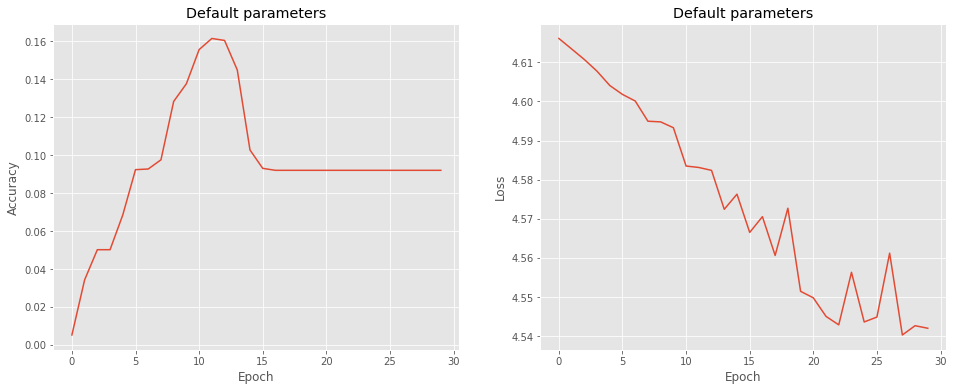

In [ ]:
net = loader.AlexNet(NUM_CLASSES, pretrained = False)
best_net_from_scratch = manager.train_from_scratch(net, train_dataloader, val_dataloader)

In [ ]:
manager.validate_net(best_net_from_scratch)
manager.test_net(best_net_from_scratch)


Validation Accuracy: 0.16153580076098237

Test Accuracy: 0.16246111303145525


## Training from scratch with different hyperparameters

Starting from the previous results, I suppose that the slowness and the uncertainty of the net is due to the small learning rate, so I try to overcome the problem trying different sets of hyperparameters to allow the model to learn faster and better. Among many trials, I report here three significant results:
1. Learning rate = 0.01: I start increasing the learning rate, and visualize results. With a learning rate equal 0.01 I reach a good accuracy on the validation set, over 30%.
2. Learning rate = 0.02: I double the learning rate, using the same hyperparameters. I achieve better results, surpassing the 40% of accuracy on the validation set. 
3. Learning rate = 0.03: I keep increasing the learning rate, getting the best results. In particular, during the 29th epoch the model is able to guess correctly more than 47% of images of the validation set. For this reason, I increase the number of epochs to allow the model to learn better. 

I tried also higher learning rate, but the model is not capable to further decrease the loss. This is due to the fact that with high learning rates the model converges to sub-optimal solutions.

best results reached during 29 epoch with (0.03, 20, 30) hyperparameters


<Figure size 432x288 with 0 Axes>

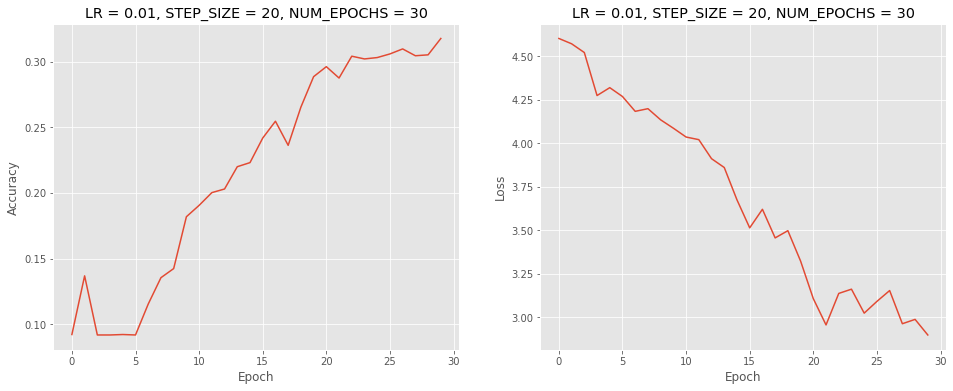

<Figure size 432x288 with 0 Axes>

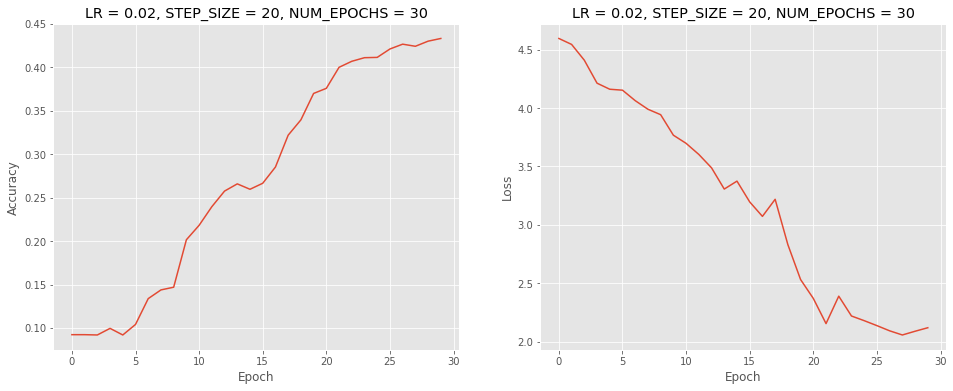

<Figure size 432x288 with 0 Axes>

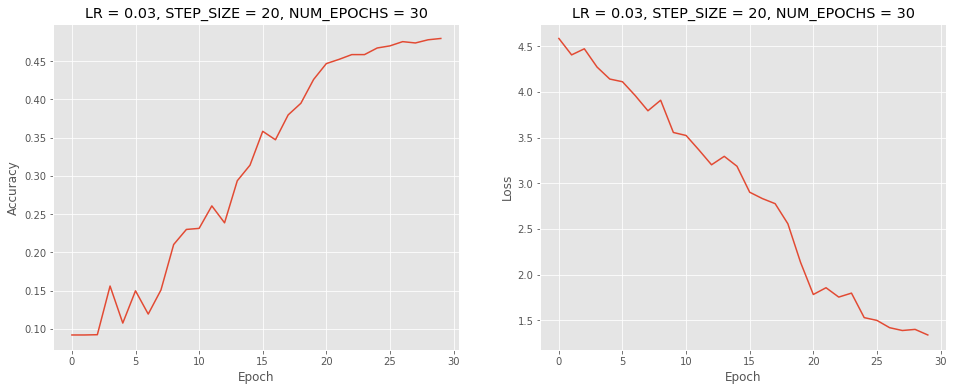

In [ ]:
net_from_scratch_best_accuracy = manager.train_from_scratch_with_hyperparameters(train_dataloader, val_dataloader, loader.hyperparameters_sets_from_scratch(), ADAM = False)

Indeed, with a 40 epochs the performance of the net improves, overcome the 50% of images correctly classified on the validation set along with the loss that get down 0.5. Although the performances are very good, it is possible to notice that the improvement are not linear with the number of epochs: during the first epochs the model improves faster. In order to get significant results in few epochs the net needs pretrained weights.

The test accuracy using the best performing model is 52%.




best results reached during 36 epoch with (0.03, 30, 40) hyperparameters


<Figure size 432x288 with 0 Axes>

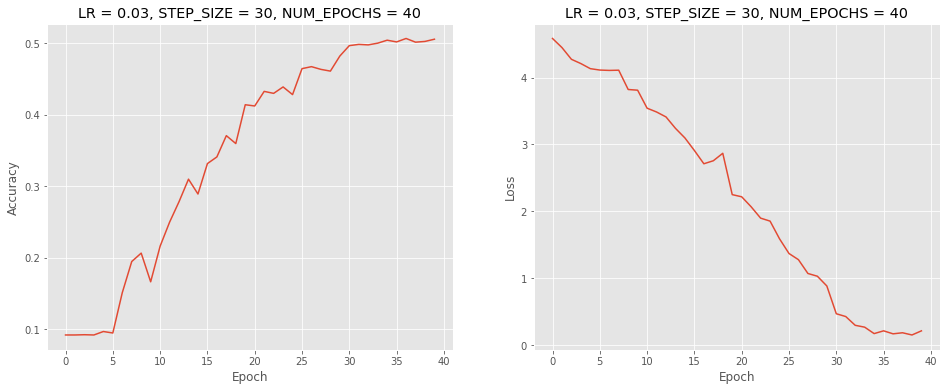

In [ ]:
net_from_scratch_best_accuracy = manager.train_from_scratch_with_hyperparameters(train_dataloader, val_dataloader, [(0.03, 30, 40)], ADAM = False)

In [ ]:
manager.validate_net(net_from_scratch_best_accuracy)

manager.test_net(net_from_scratch_best_accuracy)


Validation Accuracy: 0.5067450709097199

Test Accuracy: 0.520566885585897


# Transfer Learning

Training from scratch on 2900 images prevent the classifier to reach an acceptable level of accuracy. To enhance the performance fo the net, it is often a good choice to start the training phase using a pretrained net. In particular, I loaded AlexNet with weights trained on the ImageNet dataset, a huge dataset composed by million of images belonging to thousands of classes. 

I repeated the aferomentioned transformation on the images, except for the final one. Indeed, I normalized the images using ImageNet's mean and standard deviation. 





In [ ]:
train_transform, eval_transform = loader.pretrained_transformations()
train_dataset = Caltech(root = DATA_DIR, split = 'train.txt', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test.txt', transform=eval_transform)
train_indexes, val_indexes, train_dataset_f, val_dataset = train_dataset.__split__(0.5)
val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
train_dataloader, val_dataloader, test_dataloader = loader.dataloaders(train_dataset, val_dataset, test_dataset)


Again, among the different experiments, I report here three meaningful examples:


1.   Default hyperparameters: I started training the net using the default hyperparameters, so LR equal 0.001, Step size set to 20 and 30 epochs. It is easy to appreciate the difference of the pretrained net from the randomly inizialized. Even using a small learining rate allows the net to reach an accuracy equal to the 80% on the validation set after just 5 epochs, and then slowly further increase.
2.   I decided then to try the same hyperparameters used in the training from scratch section. Again, I reached better results. The net is now able to learn better, the asymptote is approximately around 85% while using learning rate = 0.01, and the loss decreases faster than before. I decided then to increase the number of epochs to try to further improve the accuracy, but this time the local minimum find by the net is not good enough to allow the net to be more accurate on the validation set.
3.  With higher learning rates the results are still very good, even if the net with learning rate equal to 0.01 get the best performances on the validation set. I show that set the learning rates equal to 0.02

So I tested the best performing model found using learning rate = 0.01 during the 29th epoch. The accuracy on the test set is 85.03%.

best parameters are: (0.01, 20, 30) during the 15 epoch


<Figure size 432x288 with 0 Axes>

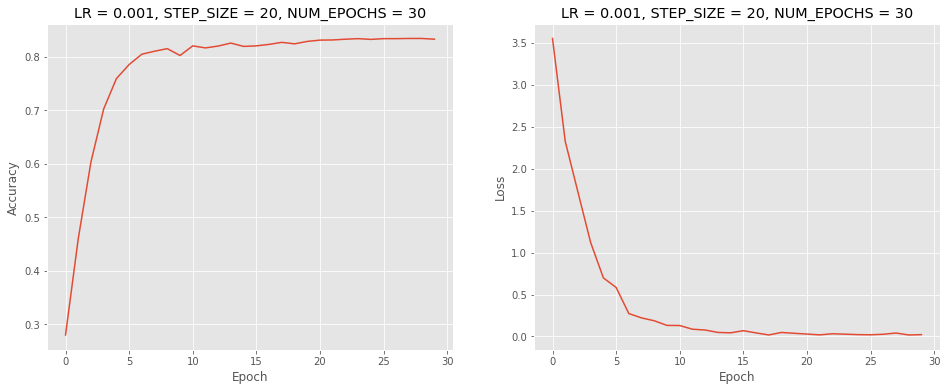

<Figure size 432x288 with 0 Axes>

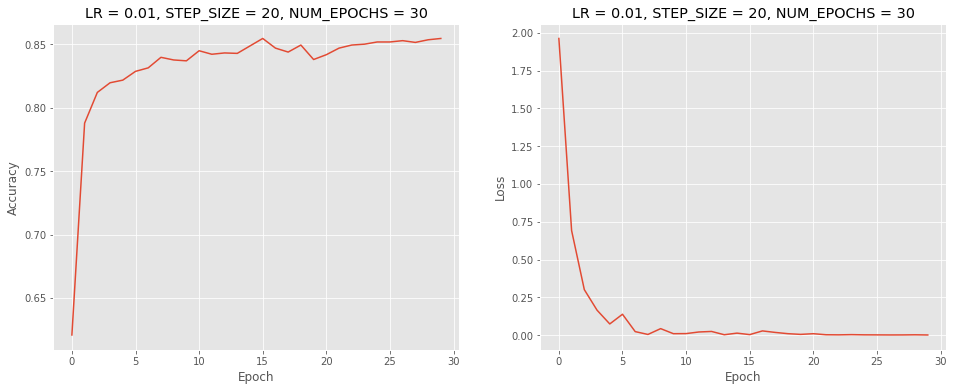

<Figure size 432x288 with 0 Axes>

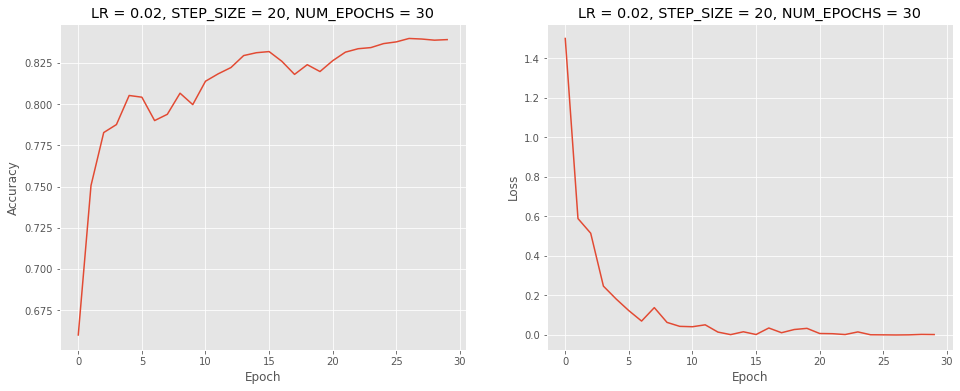

<Figure size 432x288 with 0 Axes>

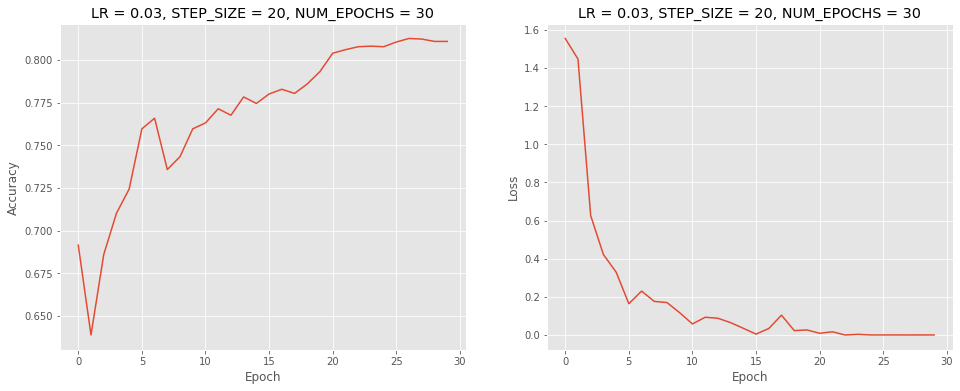

In [30]:
best_net_from_pretrained = manager.pretrained_AlexNet(loader.hyperparameters_sets_transfer_learning(), train_dataloader, val_dataloader)

In [31]:
manager.validate_net(best_net_from_pretrained)
manager.test_net(best_net_from_pretrained)


Validation Accuracy: 0.8547215496368039

Test Accuracy: 0.8541306602143104


best parameters are: (0.01, 30, 40) during the 39 epoch


<Figure size 432x288 with 0 Axes>

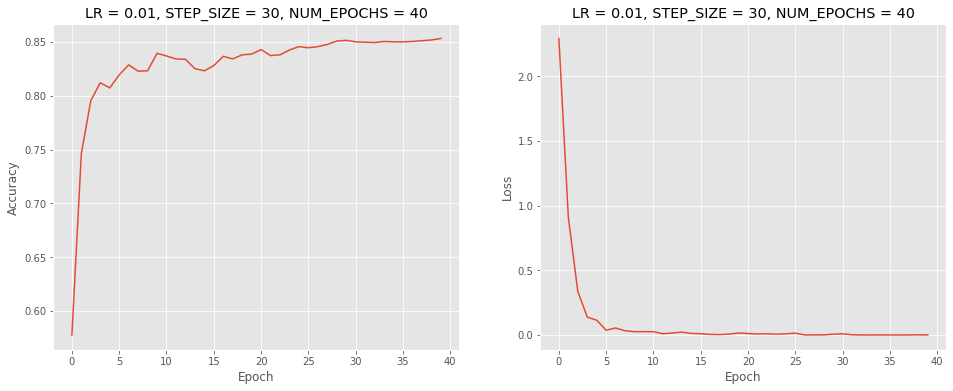

In [33]:
best_net_from_pretrained = manager.pretrained_AlexNet([(0.01,30,40)], train_dataloader, val_dataloader)

In [34]:
manager.validate_net(best_net_from_pretrained)
manager.test_net(best_net_from_pretrained)


Validation Accuracy: 0.8533379453476306

Test Accuracy: 0.8444521258209471


## Experiments: training only the fully connected layers and only the convolutional layers

As suggested, I try to freeze part of the network, that means training only certain layers. It can prevent overfitting and speed up the training phase. 


*   **Training only the fully connected layers**: to do that, I import the net and set the gradient computation of the convolutional layers to false. With the convolutional layers freezed, AlexNet already trained on the ImageNet dataset still extracts useful features since the first epochs. 
This happens because the Caltech101 dataset and ImageNet dataset belong to the same domain, so the net has already learnt the correct weights to understand and recognize the features of the images.
However, comparing this run with the one in which I was training the whole network, we can see that adjust a little also the weights of the convolutional layers guarantees a slightly higher accuracy in long terms. The accuracy reached with this run is around 84.1%
*   **Training only the convolutional layers**: with the same procedure, this time the fully connected layers are freezed. The results are not the same: the fully connected layers, including the classificator, are trained to recognized the first 101 classes of ImageNet, that are different from the Caltech 101 classes. Altough training the feature extractor effects the results somehow, the net can't reach the 60% of accuracy and the loss is not able to decrease under the 1.5 threshold, a bad results compared to the previuos ones.

I tested the first net trained only on the fully connected layers, that gave the best performances during the 24th epoch, obtaining 84.4% of accuracy on the test set.



best results are reached during the 24th epoch


<Figure size 432x288 with 0 Axes>

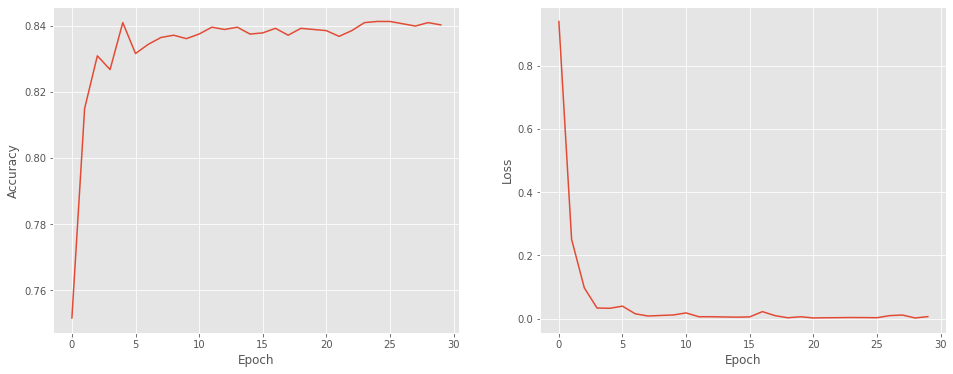

In [ ]:
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
for param in net.features.parameters():
  param.requires_grad = False
net = net.to(DEVICE)

FC_best_params = manager.train_fc_layers_pretrained_net(net, (0.01, 20, 30))

In [ ]:
manager.validate_net(FC_best_params)
manager.test_net(FC_best_params)


Validation Accuracy: 0.8412314078173643

Test Accuracy: 0.8444521258209471


best results are reached during the 28th epoch


<Figure size 432x288 with 0 Axes>

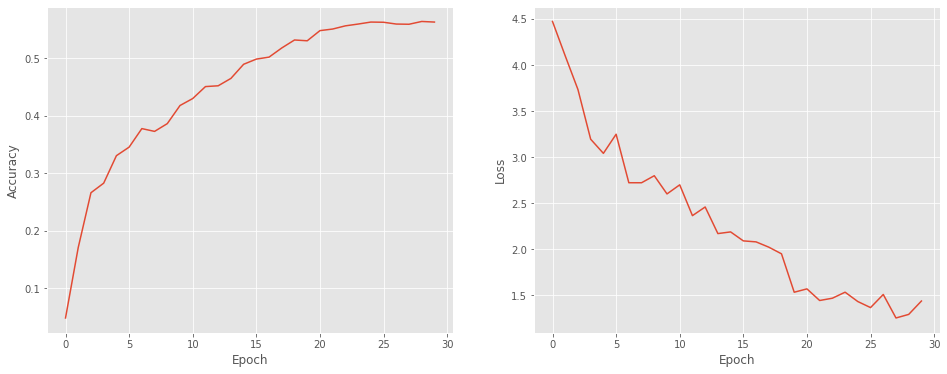

In [12]:
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
for param in net.classifier.parameters():
  param.requires_grad = False
net = net.to(DEVICE)

CL_best_params = manager.train_conv_layers_pretrained_net(net, (0.01, 20, 30))

In [13]:
manager.validate_net(CL_best_params)

manager.test_net(CL_best_params)


Validation Accuracy: 0.5638187478381183

Test Accuracy: 0.5610093328724507


# Data Augmentation

Data augmentation is one of the various techniques to reduce overfitting and to regularize data. Using PyTorch it works in the following way: in any epoch the dataloader will apply a fresh set of previously chosen random operations “on the fly”. So instead of showing the exact same items at every epoch, it is shown a variant that has been changed in a different way. So, for example, after three epochs, you would have seen three random variants of each item in a dataset.

I applied three different set of transformations, that have in common a random crop so the images are no more cropped in the center:

*   Color jitter(brightness=0.5): the color is jittered brightness. 
*   Random horizontal flip(with probability=0.5): the images are rotated on the horizontal axis with a probability of 0.5.
*   A combination of the precedents. 
*  Color jitter, random horizontal flip and random vertical flip: I decide to add also the random vertical flip, so the images are rotated on the vertical axis with a probability of 0.5 as well.

I use the default set of hyperaparameters, in order to have a fair comparison between them and the performances of the net trained without data augmentation. The results are quite similar between them. I associate this with the fact that the pretrained AlexNet has already seen millions of images, and a few thousands of images modified are not useful to train the model also for this specific task. 


<Figure size 432x288 with 0 Axes>

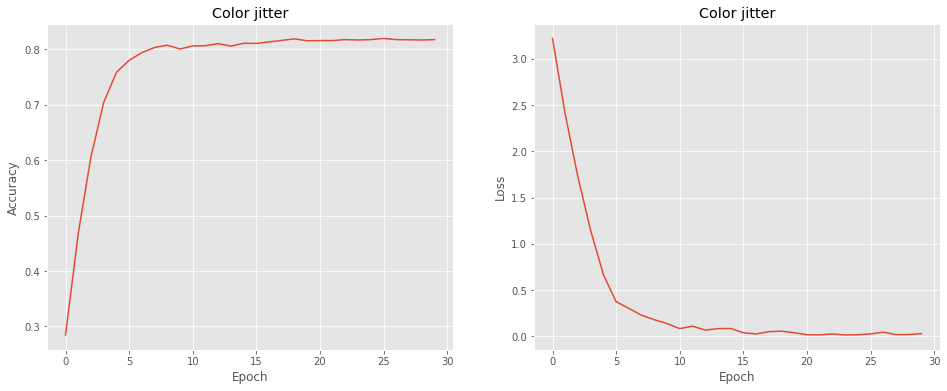

<Figure size 432x288 with 0 Axes>

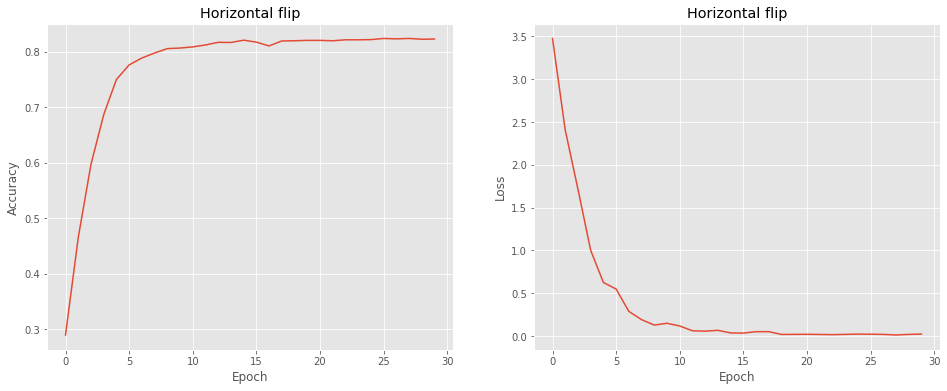

<Figure size 432x288 with 0 Axes>

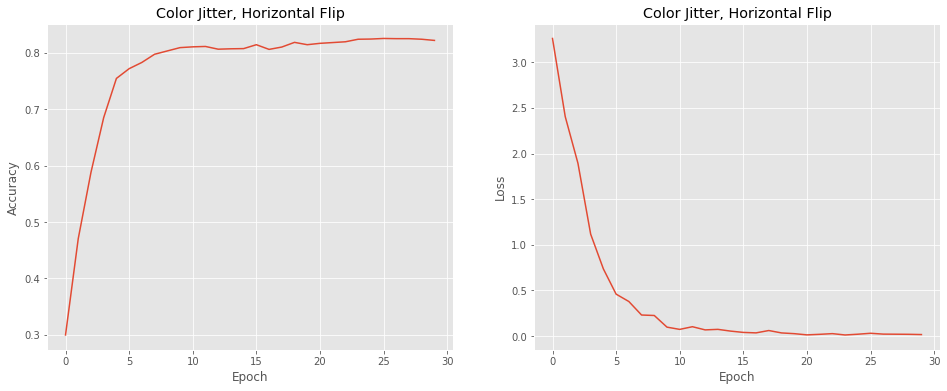

<Figure size 432x288 with 0 Axes>

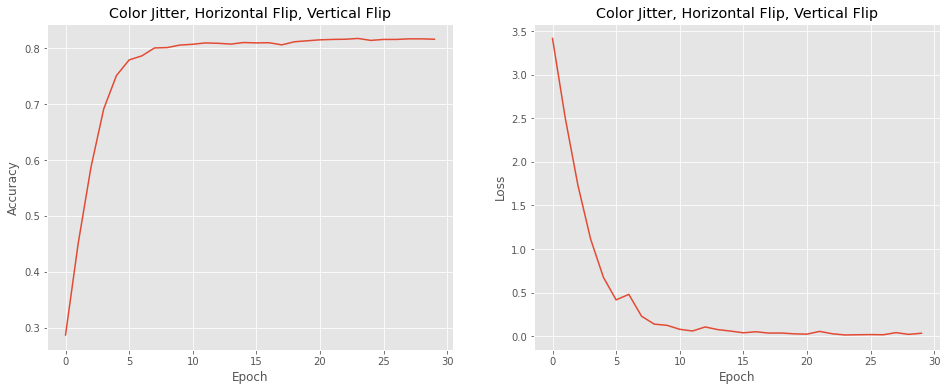

In [19]:
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()
transformations_sets = loader.transformations_for_data_augmentation()

manager.pretrained_net_with_transformed_data(transformations_sets)

# Extra Point: ResNet18
Before the presentation of the ResNet architecture, one of the main problems in the Deep Learning community was that deeper architectures worsened the results. Indeed, it is shown in the ResNet paper that a network with 56 layers has an higher training error respect to a 20 layers network. This is called the degradation problem. With the network depth increasing the accuracy saturates and then begins to degrade rapidly if more layers are introduced. If those layers that are introduced would have been the identity mapping the results wouldn't worsened, hence, in theory, deeper networks should perform at least as their shallow counterparts. To put this in pratice, residual networks have been introduce: residual networks instead of hoping that the layers fit the desired mapping, we let these layers fit a residual mapping. Initially, the desired mapping is $H(x)$. We let the networks, however, to fit the residual mapping $F(x)=H(x)-x$, as the network found it easier to optimize the residual mapping rather than the original mapping.
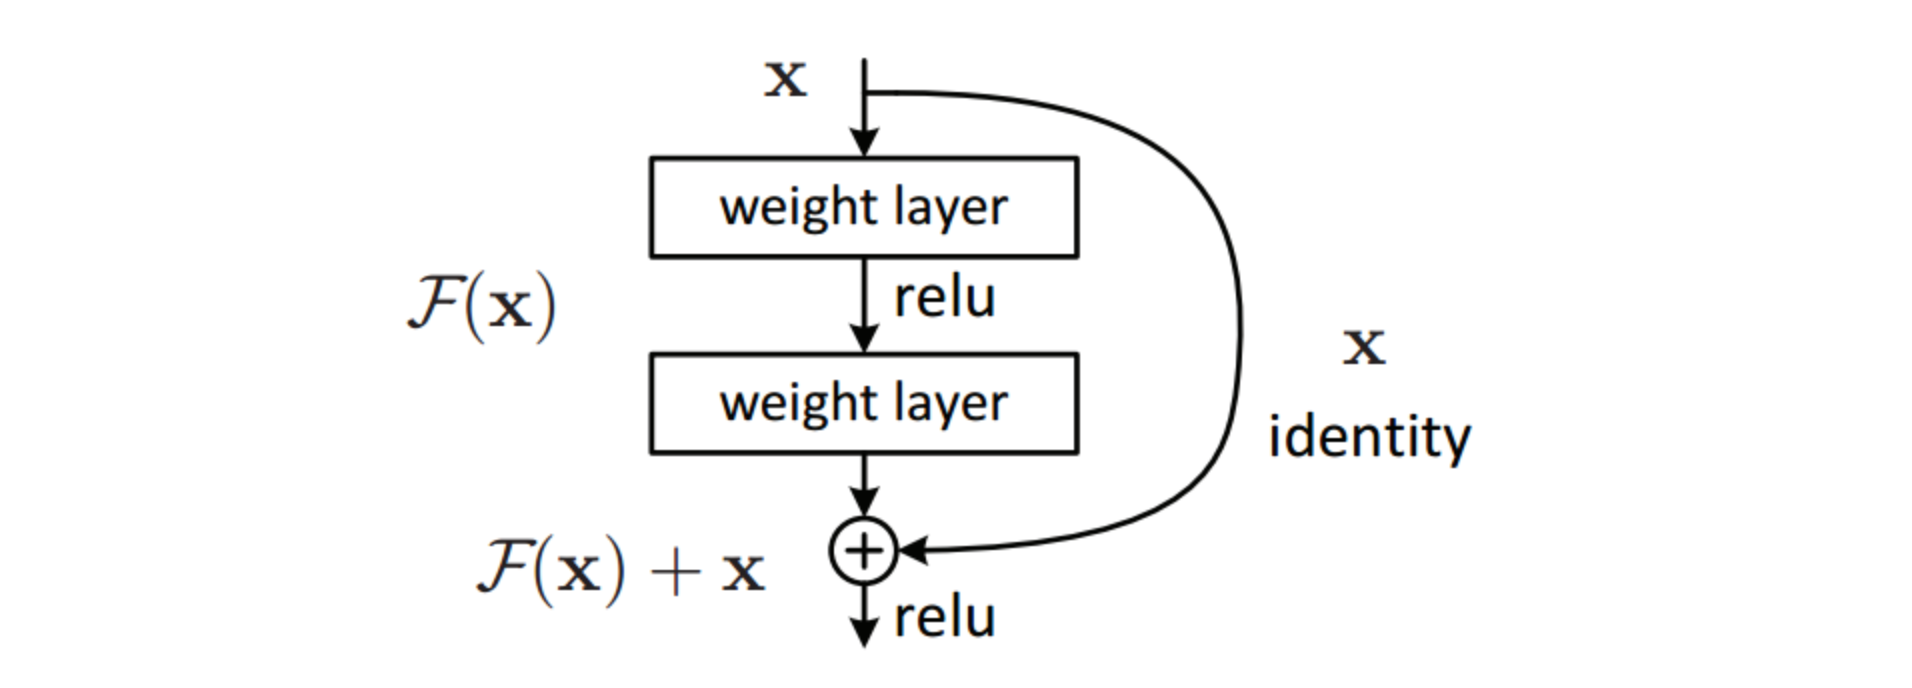
This method of bypassing the data from one layer to another is known as skip connections. This approach allows the data to flow easily between the layers without hampering the learning ability of the deep learning model. The advantage of adding this type of skip connection is that if any layer hurts the performance of the model, it will be skipped.

## My implementation
In order to use this architecture I must change the batch size, that I set equal to 128. I preload the weights as I did for AlexNet and I use the set of hyperparameters that performs better on AlexNet with pretrained weights, namely: LR=0.01, step size=20, number of epochs equal to 30 in order to compare the performances of the two architectures.

The results are outstanding: the ResNet18 is able to reach an accuracy higher than 90% after few epochs. In particular is able to classify correctly the 93% of images of the test set.

best parameters are: (0.01, 20, 30) during the 24 epoch


<Figure size 432x288 with 0 Axes>

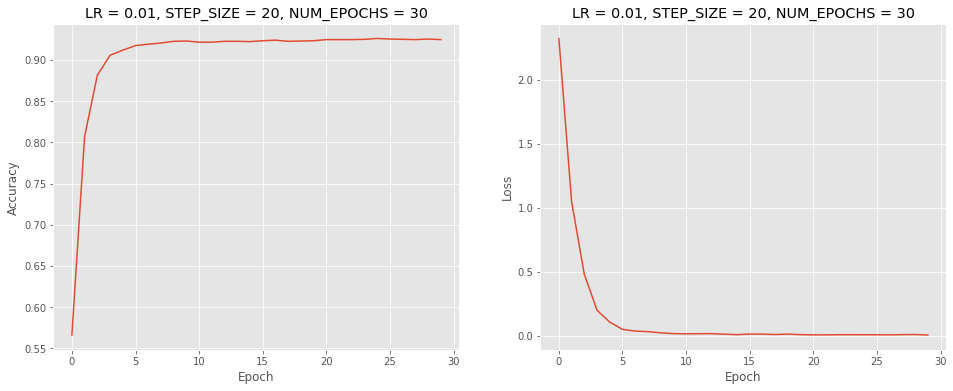

In [ ]:
DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()  
BATCH_SIZE = 128
train_transform, eval_transform = loader.pretrained_transformations()
train_dataset = Caltech(root = DATA_DIR, split = 'train.txt', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test.txt', transform=eval_transform)
train_indexes, val_indexes, train_dataset_f, val_dataset = train_dataset.__split__(0.5)
val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
train_dataloader, val_dataloader, test_dataloader = loader.dataloaders(train_dataset, val_dataset, test_dataset)

hyperparameters_sets = [(0.01, 20, 30)]

best_resnet = manager.pretrained_ResNet(hyperparameters_sets, train_dataloader, val_dataloader)

In [ ]:
manager.validate_net(best_resnet)
manager.test_net(best_resnet)


Validation Accuracy: 0.9245935662400554

Test Accuracy: 0.9319045973038369


# Manager

In [1]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 734.6MB 23kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
     |████████████████████████████████| 4.0MB 14.7MB/s 
     |████████████████████████████████| 753.4MB 23kB/s 
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 634kB 12.4MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110318 sha256=53f8e119571cde1cda37b6ed2ee1e76f318a6fcad921c2be1d8218f721c38b7d
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d51

In [26]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader, random_split
from torch.backends import cudnn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import resnet18
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from tqdm import tqdm

from google.colab import output

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'

from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys
import natsort
import numpy as np


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
        self.root = root

        self.matrix = []
        self.matrix1 = []
        with open(os.path.join(os.getcwd(), 'Caltech101', self.split), 'r') as f:
           split_dir = f.read().splitlines() 

        categories = os.listdir(self.root)
        categories = natsort.natsorted(categories)
        del categories[:1]
        self.nlabels = categories
        categories = {i : categories[i] for i in range(0, len(categories))}

        for cat in categories.items():
            imgages = os.listdir(os.path.join(self.root, cat[1]))

            for image in imgages:
              final_path = os.path.join(cat[1], image)
              if final_path in split_dir:
                self.matrix.append([pil_loader(os.path.join(self.root, cat[1], image)), int(cat[0])])
                self.matrix1.append([os.path.join(self.root,cat[1], image), int(cat[0])])

        self.final_result = self.matrix
        

    def __getdataset__(self):

        return self.final_result
      
    def number_labels(self):

        return self.nlabels


    def __split__(self, length):

        self.length = length

        self.matrix1 = np.array(self.matrix1)

        set_of_labels = set(self.matrix1[:,1])
        datasetA = np.empty(shape=[0,2])
        datasetB = np.empty(shape=[0,2])
        idx_track1 = np.empty(shape=[0,1])
        idx_track2 = np.empty(shape=[0,1])
        for label in set_of_labels:
          temp_idx = []
          for i in range(len(self.matrix1)):
            if label == self.matrix1[i][1]:
              temp_idx.append(i)

          choices1 = np.random.choice(temp_idx, size = round(len(temp_idx)*self.length), replace = False)
          choices2 = np.array([el for el in temp_idx if el not in choices1])
          idx_track1 = np.append(idx_track1, choices1)
          idx_track2 = np.append(idx_track2, choices2)
          datasetA = np.append(datasetA, self.matrix1[[choices1]], axis=0)
          datasetB = np.append(datasetB, self.matrix1[[choices2]], axis=0)
        return idx_track1.astype(int), idx_track2.astype(int), datasetA, datasetB

    def __getitem__(self, index):
      

        image, label = self.final_result[index][0], int(self.final_result[index][1]) 

        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):

        length = len(self.final_result) 

        return length

class Plot():
  def __init__(self):
    pass

  def accuracies_and_losses(self, accuracies, losses, title=""):
    accuracy_df = pd.DataFrame(accuracies)
    accuracy_df = accuracy_df.astype(float)
    accuracy_df.columns=['Epoch','Accuracy']

    loss_df = pd.DataFrame(losses)
    loss_df = loss_df.astype(float)
    loss_df.columns=['Epoch','Loss']

    plt.figure()  
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(x='Epoch',y='Accuracy',data=accuracy_df, markers=True, dashes=False,  ax = ax[0]).set_title(title)
    sns.lineplot(x='Epoch',y='Loss',data=loss_df, markers=True, dashes=False,  ax = ax[1]).set_title(title)

class Loader():
  def __init__(self):
    global train_dataset, val_dataset, test_dataset

  def default_parameters(self):
    default_DEVICE = 'cuda'
    default_NUM_CLASSES = 101 
    default_BATCH_SIZE = 256 
    default_LR = 0.001           
    default_MOMENTUM = 0.9      
    default_WEIGHT_DECAY = 5e-5  
    default_NUM_EPOCHS = 30
    default_STEP_SIZE = 20   
    default_GAMMA = 0.1    
    default_LOG_FREQUENCY = 10
    return default_DEVICE, default_NUM_CLASSES, default_BATCH_SIZE, default_LR, default_MOMENTUM, default_WEIGHT_DECAY, default_NUM_EPOCHS, default_STEP_SIZE, default_GAMMA, default_LOG_FREQUENCY

  def AlexNet(self, NUM_CLASSES, pretrained):

    net = alexnet(pretrained) 

    net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

    net.to(DEVICE)

    return net

  def ResNet(self, NUM_CLASSES, pretrained):

    net = resnet18(pretrained) 

    num_ftrs = net.fc.in_features
    net.fc = nn.Linear(num_ftrs, NUM_CLASSES)   
    net.to(DEVICE)

    return net

  def default_transformations(self):

    default_transformations = (
            transforms.Compose([transforms.Resize(256),      
                                transforms.CenterCrop(224),  
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
            ]),
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
            ]))
    return default_transformations

  def pretrained_transformations(self):

    pretrained_transformations = (
            transforms.Compose([transforms.Resize(256),      
                                transforms.CenterCrop(224),  
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]),
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]))
    
    return pretrained_transformations
    
  def dataloaders(self, train_dataset, val_dataset, test_dataset):
    return (DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True),
            DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4),
            DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4))
  
  def criterion_optimizer_scheduler(self, net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, LOG_FREQUENCY):
    criterion = nn.CrossEntropyLoss() 
    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    return criterion, optimizer, scheduler
    

  def hyperparameters_sets_from_scratch(self):

    hyperparameters_sets = [(0.01, 20, 30),
                            (0.02, 20, 30),
                            (0.03, 20, 30)]
    return hyperparameters_sets
    
  def hyperparameters_sets_transfer_learning(self):

    hyperparameters_sets = [(0.001, 20, 30), 
                            (0.01, 20, 30), 
                            (0.02, 20, 30),         
                            (0.03, 20, 30)]
    return hyperparameters_sets
    
  def transformations_for_data_augmentation(self):
    transformations_for_data_augmentation = [

            (transforms.Compose([         transforms.Resize(256),   
                                          transforms.RandomCrop(224),  
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            transforms.Compose([          transforms.Resize(256),
                                          transforms.RandomCrop(224),
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            "Color jitter"),
              
            (transforms.Compose([         transforms.Resize(256),   
                                          transforms.RandomCrop(224),  
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            transforms.Compose([          transforms.Resize(256),
                                          transforms.RandomCrop(224),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            "Horizontal flip"),
              
            (transforms.Compose([         transforms.Resize(256),   
                                          transforms.RandomCrop(224),
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.RandomHorizontalFlip(p=0.5),  
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            transforms.Compose([          transforms.Resize(256),
                                          transforms.RandomCrop(224),
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            "Color Jitter, Horizontal Flip"),
            (transforms.Compose([         transforms.Resize(256),   
                                          transforms.RandomCrop(224),
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.RandomHorizontalFlip(p=0.5),  
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            transforms.Compose([          transforms.Resize(256),
                                          transforms.RandomCrop(224),
                                          transforms.ColorJitter(brightness=0.5),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.RandomVerticalFlip(p=0.5),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            ]),
            "Color Jitter, Horizontal Flip, Vertical Flip"),
            ]
    return transformations_for_data_augmentation

    class Manager():
  def __init__(self):
    pass
  
  def train_from_scratch(self, net, train_dataloader, val_dataloader):
    
    criterion, optimizer, scheduler = loader.criterion_optimizer_scheduler(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, LOG_FREQUENCY)
    best_acc = 0
    best_params = ''
    accuracies = []
    losses = []

    cudnn.benchmark 

    current_step = 0

    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

      # Iterate over the dataset
      for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train() # Sets module in training mode
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = net(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients

        current_step += 1

      # Evaluate network on validation set
      accuracy = self.evaluate_neural_network_on_validation_set(net, val_dataloader)
      if accuracy > best_acc:
        best_acc=accuracy
        best_model= copy.deepcopy(net)
        best_params = 'higher validation accuracy at epoch number ' + str(epoch) 

      accuracies.append( (epoch, accuracy) )
      losses.append( (epoch, loss) )

      # Step the scheduler
      scheduler.step()

    output.clear()
    print(best_params)
    plot.accuracies_and_losses(accuracies, losses, "Default parameters")
    return best_model

  def train_from_scratch_with_hyperparameters(self, train_dataloader, val_dataloader, hyperparameters_sets, ADAM):

    DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()

    accuracies = dict()
    losses = dict()
    nets_best_accuracy = dict()
    best_acc = 0
    best_params = ''

    for hyperparameter_set in hyperparameters_sets:
      LR = hyperparameter_set[0]
      STEP_SIZE = hyperparameter_set[1]
      NUM_EPOCHS = hyperparameter_set[2]

      print("\nHyperparameter set:")
      print(hyperparameter_set)
      accuracies[hyperparameter_set] = []
      losses[hyperparameter_set] = []
      
      net = loader.AlexNet(NUM_CLASSES, pretrained = False)

      criterion = nn.CrossEntropyLoss() 
      parameters_to_optimize = net.parameters()
      
      
      if ADAM == True:
        optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)
        print('ADAM is used')
      else:
        optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      cudnn.benchmark 

      for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        net.train(True)

        for images, labels in train_dataloader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()  
          optimizer.step() 

        accuracy = self.evaluate_neural_network_on_validation_set(net, val_dataloader)
        accuracies[hyperparameter_set].append( (epoch, accuracy) )
        losses[hyperparameter_set].append( (epoch, loss.item()))

        scheduler.step()
        
        if accuracy>best_acc:
          best_acc=accuracy
          best_model=copy.deepcopy(net)
          best_params = f'best results reached during {str(epoch)} epoch with {hyperparameter_set} hyperparameters'

      output.clear()

    # Plot results
    print(best_params)
    for hyperparameter_set in hyperparameters_sets:
      plot.accuracies_and_losses(accuracies[hyperparameter_set],losses[hyperparameter_set], 
                                "LR = " + str(hyperparameter_set[0]) + ", " + 
                                "STEP_SIZE = " + str(hyperparameter_set[1]) + ", " + 
                                "NUM_EPOCHS = " + str(hyperparameter_set[2]))
    
    return best_model
    pass 

  def pretrained_AlexNet(self, hyperparameters_sets, train_dataloader, val_dataloader):
    #global train_dataloader

    DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()
   
    # Define structures for accuracies and losses
    accuracies = dict()
    losses = dict()
    nets_best_accuracy = dict()
    best_acc = 0

    for hyperparameter_set in hyperparameters_sets:

      LR = hyperparameter_set[0]
      STEP_SIZE = hyperparameter_set[1]
      NUM_EPOCHS = hyperparameter_set[2]

      print("\n Hyperparameter set:")
      print(hyperparameter_set)
      accuracies[hyperparameter_set] = []
      losses[hyperparameter_set] = []
      
      # Prepare Network
      net = loader.AlexNet(NUM_CLASSES, pretrained = True) # Loading AlexNet model

      criterion, optimizer, scheduler = loader.criterion_optimizer_scheduler(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, LOG_FREQUENCY)

      cudnn.benchmark 

      best_accuracy = float(0)
      filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

      for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        for images, labels in train_dataloader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()  
          optimizer.step() 

        scheduler.step()

        accuracy = self.evaluate_neural_network_on_validation_set(net, val_dataloader)
        if accuracy>best_acc:
          best_acc=accuracy
          best_model=copy.deepcopy(net)
          best_params = f'best parameters are: {hyperparameter_set} during the {str(epoch)} epoch'

        accuracies[hyperparameter_set].append( (epoch, accuracy) )
        losses[hyperparameter_set].append( (epoch, loss.item()))
        
      output.clear()

    print(best_params)
    for hyperparameter_set in hyperparameters_sets:
      plot.accuracies_and_losses(accuracies[hyperparameter_set],losses[hyperparameter_set], 
                                "LR = " + str(hyperparameter_set[0]) + ", " + 
                                "STEP_SIZE = " + str(hyperparameter_set[1]) + ", " + 
                                "NUM_EPOCHS = " + str(hyperparameter_set[2]))
    return best_model
    pass

  def train_fc_layers_pretrained_net(self, net, hyperparameters):
    #global NUM_EPOCHS, train_dataloader

    DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()

    LR = hyperparameters[0]
    STEP_SIZE = hyperparameters[1]
    NUM_EPOCHS = hyperparameters[2]

    losses = []
    accuracies = []
    best_acc = 0
    
    criterion, optimizer, scheduler = loader.criterion_optimizer_scheduler(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, LOG_FREQUENCY)

    cudnn.benchmark 
  
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

      for images, labels in train_dataloader:

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step() 


      scheduler.step()
      
      # Evaluate network on validation set, save accuracy and loss
      accuracy = self.evaluate_neural_network_on_validation_set(net, val_dataloader)
      #_ = self.evaluate_neural_network_on_train_set(net, train_dataloader)
      if accuracy>best_acc:
          best_acc=accuracy
          best_model=copy.deepcopy(net)
          best_params = f'best results are reached during the {str(epoch)}th epoch'

      accuracies.append( (epoch, accuracy) )
      losses.append( (epoch, loss.item()))
        
    output.clear()

    # Plot results
    print(best_params)
    plot.accuracies_and_losses(accuracies, losses)
    return best_model
    pass

  def train_conv_layers_pretrained_net(self, net, hyperparameters):
    #global NUM_EPOCHS, train_dataloader
    
    DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()

    LR = hyperparameters[0]
    STEP_SIZE = hyperparameters[1]
    NUM_EPOCHS = hyperparameters[2]

    losses = []
    accuracies = []
    best_acc = 0

    criterion, optimizer, scheduler = loader.criterion_optimizer_scheduler(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, LOG_FREQUENCY)

    cudnn.benchmark 


    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

      for images, labels in train_dataloader:

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train()
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step() 

      scheduler.step()
      
      # Evaluate network on validation set, save accuracy and loss
      accuracy = self.evaluate_neural_network_on_validation_set(net, val_dataloader) 
      #_ = self.evaluate_neural_network_on_train_set(net, train_dataloader)
      if accuracy>best_acc:
          best_acc=accuracy
          best_model=copy.deepcopy(net)
          best_params = f'best results are reached during the {str(epoch)}th epoch'

      accuracies.append( (epoch, accuracy) )
      losses.append( (epoch, loss.item()))
        
    output.clear()

    # Plot results
    print(best_params)
    plot.accuracies_and_losses(accuracies, losses)
    return best_model
    pass
  
  def pretrained_net_with_transformed_data(self, transformations_sets):
    #global NUM_EPOCHS, train_dataloader
    accuracies = dict()
    losses = dict()
    nets_best_accuracy = dict()
    best_acc = 0

    for transformations_set in transformations_sets:
      train_transform = transformations_set[0]
      eval_transform = transformations_set[1]
      title = transformations_set[2]

      val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
      train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

      # Initialize structures for accuracies and losses
      accuracies[transformations_set] = []
      losses[transformations_set] = []
      
      # Prepare Network
      net = loader.AlexNet(NUM_CLASSES, pretrained = True)

      # Prepare Training
      criterion = nn.CrossEntropyLoss()
      parameters_to_optimize = net.parameters() 
      optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

      cudnn.benchmark 

      best_acc = 0

      for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        for images, labels in train_dataloader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()  
          optimizer.step()

        scheduler.step()

        accuracy = self.evaluate_neural_network_on_validation_set(net, val_dataloader) 
        accuracies[transformations_set].append( (epoch, accuracy) )
        losses[transformations_set].append( (epoch, loss.item()))
        
        if accuracy>best_acc:
          best_acc=accuracy
          best_model=copy.deepcopy(net)
          best_params = f'best results are reached during the {str(epoch)}th epoch'

      output.clear()

    for transformations_set in transformations_sets:
      plot.accuracies_and_losses(accuracies[transformations_set],losses[transformations_set], transformations_set[2])

    return
    pass

  def pretrained_ResNet(self, hyperparameters_sets, train_dataloader, val_dataloader):

    DEVICE, NUM_CLASSES, BATCH_SIZE, LR, MOMENTUM, WEIGHT_DECAY, NUM_EPOCHS, STEP_SIZE, GAMMA, LOG_FREQUENCY = loader.default_parameters()
   
    BATCH_SIZE = 128
    accuracies = dict()
    losses = dict()
    nets_best_accuracy = dict()
    best_acc = 0

    for hyperparameter_set in hyperparameters_sets:
      LR = hyperparameter_set[0]
      STEP_SIZE = hyperparameter_set[1]
      NUM_EPOCHS = hyperparameter_set[2]

      print("\n Hyperparameter set:")
      print(hyperparameter_set)
      accuracies[hyperparameter_set] = []
      losses[hyperparameter_set] = []

      net = loader.ResNet(NUM_CLASSES, pretrained = True) # Loading ResNet model

      criterion, optimizer, scheduler = loader.criterion_optimizer_scheduler(net, LR, MOMENTUM, WEIGHT_DECAY, STEP_SIZE, GAMMA, LOG_FREQUENCY)

      cudnn.benchmark 
      net.train(True)
      best_accuracy = float(0)
      filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

      for epoch in range(NUM_EPOCHS):
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

        for images, labels in train_dataloader:

          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train()
          optimizer.zero_grad()
          outputs = net(images)
          loss = criterion(outputs, labels)
          loss.backward()  
          optimizer.step() 

        scheduler.step()

        accuracy = self.evaluate_neural_network_on_validation_set(net, val_dataloader)
        if accuracy>best_acc:
          best_acc=accuracy
          best_model=net
          best_params = f'best parameters are: {hyperparameter_set} during the {str(epoch)} epoch'

        #_ = self.evaluate_neural_network_on_train_set(net, train_dataloader)
        accuracies[hyperparameter_set].append( (epoch, accuracy) )
        losses[hyperparameter_set].append( (epoch, loss.item()))
        
      output.clear()

    # Plot results
    print(best_params)
    for hyperparameter_set in hyperparameters_sets:
      plot.accuracies_and_losses(accuracies[hyperparameter_set],losses[hyperparameter_set], 
                                "LR = " + str(hyperparameter_set[0]) + ", " + 
                                "STEP_SIZE = " + str(hyperparameter_set[1]) + ", " + 
                                "NUM_EPOCHS = " + str(hyperparameter_set[2]))
                                
    return best_model
    pass

  def evaluate_neural_network_on_validation_set(self, net, val_dataloader):

    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in val_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    print('Validation Accuracy: {}'.format(accuracy))
    print("\n")

    net.train(True)

    return accuracy

  def evaluate_neural_network_on_train_set(self, net, train_dataloader):

    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in train_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    print('Training accuracy: {}'.format(accuracy))
    print("\n")

    return accuracy

  def validate_net(self, net):

    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in val_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(val_dataset))

    print('\nValidation Accuracy: {}'.format(accuracy))

  def test_net(self, net):

    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode

    running_corrects = 0
    for images, labels in test_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    print('\nTest Accuracy: {}'.format(accuracy))

# Initialize classes used and hyperparameters
loader = Loader()
manager = Manager()
plot = Plot()

